In [58]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import jaxopt
except ImportError:
    %pip install -q jaxopt

(classification)=

## GP Classification

In [103]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

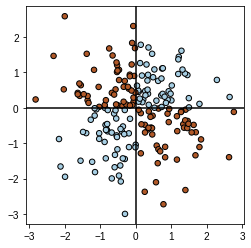

In [104]:
X = jax.random.normal(jax.random.PRNGKey(1234), (200, 2))
y = jnp.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

plt.scatter(
    X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0)
)
plt.gca().set_aspect("equal")
_ = plt.axhline(0, color="k")
_ = plt.axvline(0, color="k")

In [105]:
xs = jnp.linspace(-2, 2, num=100)
ys = jnp.linspace(-2, 2, num=100)

xx, yy = jnp.meshgrid(xs, ys)
xx = xx.T
yy = yy.T
T = jnp.vstack((xx.ravel(), yy.ravel())).T

In [106]:
y_T = jnp.logical_xor(T[:, 0] > 0, T[:, 1] > 0)

In [107]:
# T[T[:, 0] == -2]

In [108]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import zeros
from tinygp import kernels, transforms, GaussianProcess


class RBFLoss(nn.Module):
    @nn.compact
    def __call__(self, X, y, T):
        # Set up a typical Squared Exponential kernel
        log_sigma = self.param("log_sigma", zeros, ())
        log_ell = self.param("log_ell", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())
        base_kernel = jnp.exp(2 * log_sigma) * kernels.ExpSquared(
            scale = jnp.exp(log_ell)
        )

        # Evaluate and return the GP negative log likelihood as usual
        gp = GaussianProcess(base_kernel, X, diag=jnp.exp(2 * log_jitter))
        log_prob, gp_cond = gp.condition(y, T)
        return -log_prob, (gp_cond.loc, gp_cond.variance)


def loss(params):
    return model.apply(params, X, y, T)[0]

In [109]:
model = RBFLoss()

In [110]:
params = model.init(jax.random.PRNGKey(1234), X, y, T)
tx = optax.sgd(learning_rate=1e-4)
opt_state = tx.init(params)


loss_grad_fn = jax.jit(jax.value_and_grad(loss))
losses = []
for i in range(1000):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

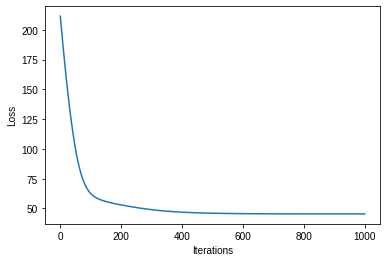

In [111]:
fig = plt.figure()
plt.plot(losses)
plt.xlabel("Iterations")
_ = plt.ylabel("Loss")

In [112]:
def rounder(x):
    if x <= 0.5:
        return 0
    else:
        return 1

In [113]:
mean, var = model.apply(params, X, y, X)[1]
y_hat = jnp.array([round(x) for x in mean])

print(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")

Accuracy: 98.50%


In [114]:
def sigmoid(x):
  return 1 / (1 + jnp.exp(-x))

In [117]:
mean, var = model.apply(params, X, y, T)[1]
y_hat = jnp.array([round(x) for x in mean])

print(f"Accuracy: {(y_hat==y_T).sum()*100/(len(y_T)) :0.2f}%")

Accuracy: 96.67%


In [118]:
def plot_pred_2d(arr, xx, yy, contour=False, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = ax.imshow(
        arr,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="equal",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    if contour:
        contours = ax.contour(
            xx,
            yy,
            sigmoid(mean).reshape(xx.shape),
            levels=[0.5],
            linewidths=2,
            colors=["k"],
        )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax.get_figure().colorbar(image, cax=cax)
    if title:
        ax.set_title(title)

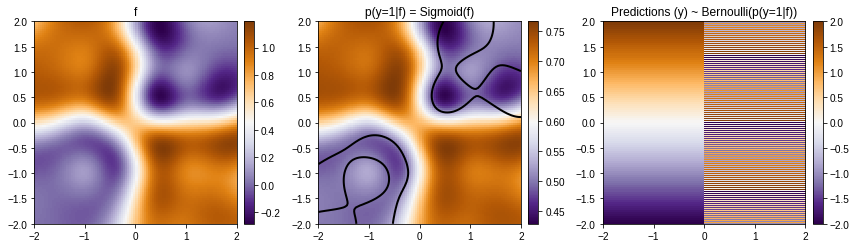

In [119]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
plot_pred_2d(mean.reshape(xx.shape), xx, yy, ax=ax[0], title="f")
plot_pred_2d(
    sigmoid(mean).reshape(xx.shape),
    xx,
    yy,
    ax=ax[1],
    title="p(y=1|f) = Sigmoid(f)",
    contour=True,
)
plot_pred_2d(T, xx, yy, ax=ax[2], title="Predictions (y) ~ Bernoulli(p(y=1|f))")

fig.tight_layout()